In [2]:
! pip3 install timm -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import h5py
import timm
import torch
import torch.nn as nn
import torchaudio
import torchvision.transforms as TF
import seaborn as sns
sns.set_theme(style='dark')


from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler

device = torch.device('cuda')
criterion = nn.BCEWithLogitsLoss()

# метаданные train
di = '../input/g2net-detecting-continuous-gravitational-waves'
df = pd.read_csv(di + '/train_labels.csv')
df = df[df.target >= 0]  # удаление меток -1

# Класс Dataset и параметры

In [4]:
transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=10),
            )

transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
            )

flip_rate = 0.0 # вероятность применения горизонтального и вертикального переворота
fre_shift_rate = 0.0 # вероятность применения вертикального сдвига

time_mask_num = 0 # количество масок по времени
freq_mask_num = 0 # количество масок по частоте

In [5]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): метка 0 или 1
    """
    def __init__(self, data_type, df, tfms=False):
        self.data_type = data_type
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): получение i-ого элемента
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # обратное преобразование Фурье

                p = a.real**2 + a.imag**2
                p /= np.mean(p)
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # 4096 -> 128
                img[ch] = p

        if self.tfms:
            if np.random.rand() <= flip_rate: # горизонтальный переворот
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= flip_rate: # вертикальный переворот
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= fre_shift_rate: # вертикальный сдвиг
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
            img = torch.from_numpy(img)

            for _ in range(time_mask_num): # маска по времени
                img = transforms_time_mask(img)
            for _ in range(freq_mask_num): # маска по частоте
                img = transforms_freq_mask(img)
        
        else:
            img = torch.from_numpy(img)
                
        return img, y

# Аугментация данных

## Горизонтальный и вертикальный переворот

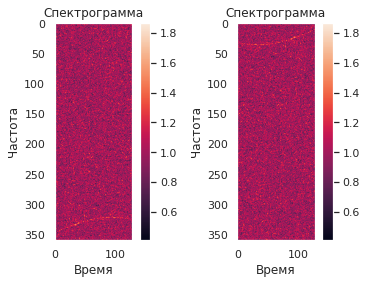

In [6]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]

plt.subplot(1, 2, 1)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()



flip_rate = 1.0

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.subplot(1, 2, 2)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()

plt.show()

## Вертикальный сдвиг

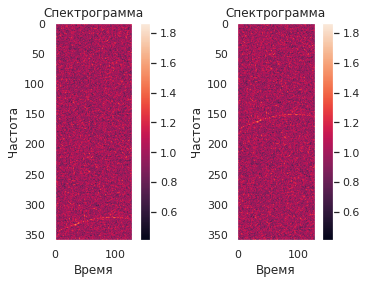

In [8]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.subplot(1, 2, 1)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()



flip_rate = 0.0
fre_shift_rate = 1.0

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.subplot(1, 2, 2)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()

plt.show()

## Маска по времени

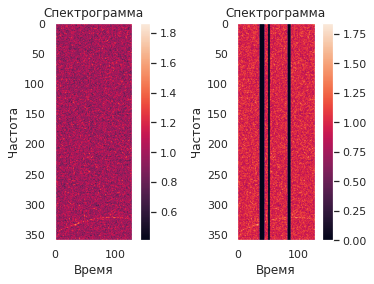

In [9]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.subplot(1, 2, 1)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()


flip_rate = 0.0
fre_shift_rate = 0.0
time_mask_num = 3

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.subplot(1, 2, 2)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()

plt.show()

## Маска по частоте

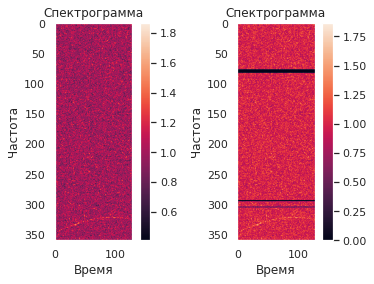

In [11]:
dataset = Dataset('train', df, tfms=False)
img, y = dataset[10]


plt.subplot(1, 2, 1)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()


flip_rate = 0.0
fre_shift_rate = 0.0
time_mask_num = 0
freq_mask_num = 3

dataset = Dataset('train', df, tfms=True)
img, y = dataset[10]

plt.subplot(1, 2, 2)
plt.title('Спектрограмма')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.imshow(img[0, 0:360])
plt.colorbar()

plt.show()

# Модель

In [35]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): название модели из timm
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=2)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.fc = nn.Linear(n_features, 1)
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

# Предсказание и оценка

In [36]:
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Предсказание и расчет loss и score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)

        with torch.no_grad():
                y_pred = model(img.to(device))

        loss = criterion(y_pred.view(-1), y)

        n_sum += n
        loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.sigmoid().squeeze().cpu().detach().numpy())

        if pbar is not None:
            pbar.update(len(img))
        
        del loss, y_pred, img, y

    loss_val = loss_sum / n_sum

    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'loss': loss_val,
           'score': score,
           'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)

    return ret

# Обучение

In [37]:
model_name = 'tf_efficientnet_b6_ns'
nfold = 5
kfold = KFold(n_splits=nfold, random_state=42, shuffle=True)

epochs = 25
batch_size = 32
num_workers = 2
weight_decay = 1e-6
max_grad_norm = 1000

lr_max = 4e-4
epochs_warmup = 1.0


## настройки аугментаций
flip_rate = 0.5
fre_shift_rate = 1.0
time_mask_num = 1
freq_mask_num = 2

for ifold, (idx_train, idx_test) in enumerate(kfold.split(df)):
    print('Fold %d/%d' % (ifold + 1, nfold))
    torch.manual_seed(42 + ifold + 1)

    # Train - val split
    dataset_train = Dataset('train', df.iloc[idx_train], tfms=True)
    dataset_val = Dataset('train', df.iloc[idx_test])

    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True, shuffle=True, drop_last=True)
    loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True)

    # Модель и оптимизатор
    model = Model(model_name, pretrained=True)
    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

    # График Learning-rate
    nbatch = len(loader_train)
    warmup = epochs_warmup * nbatch  # количество warmup шагов
    nsteps = epochs * nbatch        # общее количество шагов

    scheduler = CosineLRScheduler(optimizer,
                  warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 эпоха warmup
                  t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 эпохи cosine
    
    time_val = 0.0
    lrs = []

    tb = time.time()
    print('Epoch   loss          score   lr')
    for iepoch in range(epochs):
        loss_sum = 0.0
        n_sum = 0

        # Train
        for ibatch, (img, y) in enumerate(loader_train):
            n = y.size(0)
            img = img.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(img)
            loss = criterion(y_pred.view(-1), y)

            loss_train = loss.item()
            loss_sum += n * loss_train
            n_sum += n

            loss.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                       max_grad_norm)
            optimizer.step()
            
            scheduler.step(iepoch * nbatch + ibatch + 1)
            lrs.append(optimizer.param_groups[0]['lr'])            

        # Оценка
        val = evaluate(model, loader_val)
        time_val += val['time']
        loss_train = loss_sum / n_sum
        lr_now = optimizer.param_groups[0]['lr']
        dt = (time.time() - tb) / 60
        print('Epoch %d %.4f %.4f %.4f  %.2e  %.2f min' %
              (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))

    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))

    # Сохранение модели
    ofilename = 'model%d.pytorch' % ifold + 1
    torch.save(model.state_dict(), ofilename)
    print(ofilename, 'written')

Fold 0/5


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_ns-51548356.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b6_ns-51548356.pth


Epoch   loss          score   lr
Epoch 1 0.6434 0.6465 0.5489  4.00e-04  1.86 min
Epoch 2 0.6154 0.5634 0.6138  3.98e-04  3.94 min
Epoch 3 0.5684 0.5492 0.7059  3.93e-04  5.99 min
Epoch 4 0.5547 0.5681 0.7176  3.85e-04  7.98 min
Epoch 5 0.5394 0.4861 0.7642  3.73e-04  9.93 min
Epoch 6 0.5219 0.4892 0.7743  3.59e-04  11.83 min
Epoch 7 0.5157 0.5146 0.7319  3.42e-04  13.76 min
Epoch 8 0.5066 0.4846 0.7800  3.22e-04  15.66 min
Epoch 9 0.5083 0.4943 0.7756  3.00e-04  17.58 min
Epoch 10 0.4857 0.4802 0.7714  2.77e-04  19.53 min
Epoch 11 0.5169 0.4986 0.7547  2.52e-04  21.46 min
Epoch 12 0.4875 0.5013 0.7490  2.27e-04  23.40 min
Epoch 13 0.4890 0.4902 0.7189  2.00e-04  25.28 min
Epoch 14 0.4969 0.4846 0.7293  1.74e-04  27.20 min
Epoch 15 0.4730 0.4799 0.7398  1.49e-04  29.25 min
Epoch 16 0.4735 0.4814 0.7385  1.24e-04  31.16 min
Epoch 17 0.4698 0.4817 0.7338  1.01e-04  33.09 min
Epoch 18 0.4717 0.4870 0.7338  7.91e-05  34.97 min
Epoch 19 0.4726 0.5025 0.7290  5.94e-05  36.91 min
Epoch 20 0.4

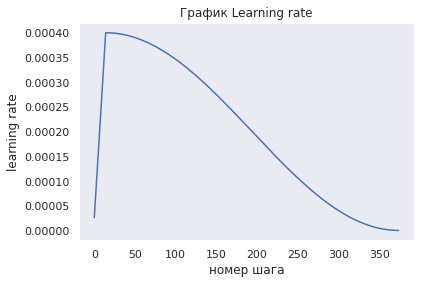

In [40]:
plt.title('График Learning rate')
plt.xlabel('номер шага')
plt.ylabel('learning rate')
plt.plot(lrs)
plt.show()

# Предсказание и сохранение в файл

In [41]:
submit = pd.read_csv(di + '/sample_submission.csv')
submit['target'] = 0
for i in range(1,6):
    model = Model(model_name, pretrained=False)
    filename = f'model{i}.pytorch'
    model.to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Предсказание
    dataset_test = Dataset('test', submit)
    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=64, num_workers=num_workers, pin_memory=True)

    test = evaluate(model, loader_test, compute_score=False, pbar=len(submit))

    # Среднее из 5
    submit['target'] += test['y_pred']/5
submit.to_csv('submission-5folds.csv', index=False)
print('target range [%.2f, %.2f]' % (submit['target'].min(), submit['target'].max()))

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

Predict:   0%|          | 0/7975 [00:00<?, ?it/s]

target range [0.40, 1.00]
